In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from dataset import QuickDrawDataset
from tqdm import tqdm

### Abstract
TODO

### Load Dataset

In [4]:
train_set = QuickDrawDataset(root="/data", train=True, download=False)
test_set = QuickDrawDataset(root="/data", train=False, download=False)

[quickdraw dataset: root=/data, train=True, download=False]
[quickdraw dataset: root=/data, train=False, download=False]


Split train dataset into train and validation

In [5]:
# train_set, val_set = random_split(train_set, [31050, 3450])

In [6]:
batch_size = 128
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [7]:
for x, y in train_set:
    print(x.shape) # (N=1, H=28, W=28)
    break

torch.Size([1, 28, 28])


### Labels for Dataset

In [8]:
categories = QuickDrawDataset.categories()
num_categories = len(categories)
len(categories)

345

### Visualize Dataset
What does an airplane look like?

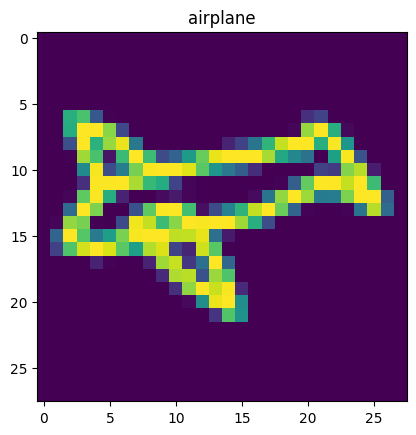

In [9]:
img, label = train_set[101]
category = categories[label]
plt.title(category)
plt.imshow(img[0])

### Define Model
MiniAlexNet: TODO

In [36]:
class MiniAlexNet(nn.Module):
    def __init__(self, labels=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            
            nn.Conv2d(96, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )
        self.nn = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(6400, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, labels),
        )

        self.init_bias()

    def init_bias(self):
        # with torch.no_grad():
        for layer in self.conv:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.conv[4].bias, 1)
        nn.init.constant_(self.conv[10].bias, 1)
        nn.init.constant_(self.conv[12].bias, 1)

    def forward(self, x):
        x = self.conv(x)

#         print(x.shape)
        x = x.reshape(x.size(0), -1)

        # print(x.shape)
        x = self.nn(x)

        return x

In [37]:
device = torch.device("mps")
# device = "cpu"
minialexnet = MiniAlexNet(labels=num_categories).to(device)
minialexnet

MiniAlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (nn): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (

### Define Loss & Optimizer

In [38]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(minialexnet.parameters(), weight_decay=0.0005, momentum=0.9, lr=0.01)

### Train Model

In [39]:
num_train_batches = len(train_dataloader)
num_train_batches

270

In [40]:
def evaluate(model, dataloader, criterion):
    total_loss = 0
    model.eval()
    
    with torch.no_grad():
        for X, Y in dataloader:
            pred = model(X.to(device))
            loss = criterion(pred, Y.to(device))
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss    

In [ ]:
epochs = 90
train_losses = []
val_losses = []

print("Training")
for epoch in range(epochs):
    # set mode to train
    minialexnet.train()
    
    total_loss = 0
    for i, (X, Y) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1} of {epochs}", leave=True)):
        pred = minialexnet(X.to(device))
        loss = cross_entropy(pred, Y.to(device))
        
        total_loss += loss.item()
        
        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # average loss over batches
    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    
    # evaluate model on validation set
    val_loss = evaluate(minialexnet, dataloader=test_dataloader, criterion=cross_entropy)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss} Val Loss: {val_loss}")

Training


Epoch 1 of 90: 100%|██████████████████████████| 270/270 [00:14<00:00, 18.94it/s]


Epoch [1/90], Loss: 5.848727333987201 Val Loss: 5.843558523390028


Epoch 2 of 90: 100%|██████████████████████████| 270/270 [00:13<00:00, 19.30it/s]


Epoch [2/90], Loss: 5.8445108131126124 Val Loss: 5.843475553724501


Epoch 3 of 90: 100%|██████████████████████████| 270/270 [00:13<00:00, 19.52it/s]


Epoch [3/90], Loss: 5.843915156964902 Val Loss: 5.84265712455467


Epoch 4 of 90: 100%|██████████████████████████| 270/270 [00:14<00:00, 19.27it/s]


Epoch [4/90], Loss: 5.769010822861283 Val Loss: 5.442041432415998


Epoch 5 of 90: 100%|██████████████████████████| 270/270 [00:13<00:00, 19.37it/s]


Epoch [5/90], Loss: 5.180219496621026 Val Loss: 4.850365974284984


Epoch 6 of 90: 100%|██████████████████████████| 270/270 [00:13<00:00, 19.50it/s]


Epoch [6/90], Loss: 4.721537097295125 Val Loss: 4.439039159704138


Epoch 7 of 90: 100%|██████████████████████████| 270/270 [00:14<00:00, 19.14it/s]


Epoch [7/90], Loss: 4.3175460250289355 Val Loss: 3.916799024299339


Epoch 8 of 90: 100%|██████████████████████████| 270/270 [00:15<00:00, 17.89it/s]


Epoch [8/90], Loss: 3.781332832795602 Val Loss: 3.5510506011821605


Epoch 9 of 90: 100%|██████████████████████████| 270/270 [00:14<00:00, 19.19it/s]


Epoch [9/90], Loss: 3.4035254345999824 Val Loss: 3.269751380991053


Epoch 10 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.31it/s]


Epoch [10/90], Loss: 3.125554605766579 Val Loss: 3.051321603633739


Epoch 11 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.29it/s]


Epoch [11/90], Loss: 2.928306977837174 Val Loss: 2.7932624375378645


Epoch 12 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.77it/s]


Epoch [12/90], Loss: 2.7340126823495936 Val Loss: 2.718615523091069


Epoch 13 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.34it/s]


Epoch [13/90], Loss: 2.5889559622164127 Val Loss: 2.646885112479881


Epoch 14 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.81it/s]


Epoch [14/90], Loss: 2.4692279427139847 Val Loss: 2.584824217690362


Epoch 15 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.79it/s]


Epoch [15/90], Loss: 2.325903390955042 Val Loss: 2.5810619725121393


Epoch 16 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.88it/s]


Epoch [16/90], Loss: 2.225621584168187 Val Loss: 2.554436030211272


Epoch 17 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.88it/s]


Epoch [17/90], Loss: 2.118399386494248 Val Loss: 2.4451884870175964


Epoch 18 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.88it/s]


Epoch [18/90], Loss: 2.026791004339854 Val Loss: 2.4247074215500444


Epoch 19 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.88it/s]


Epoch [19/90], Loss: 1.9367280324300131 Val Loss: 2.362658562483611


Epoch 20 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.82it/s]


Epoch [20/90], Loss: 1.8466579649183485 Val Loss: 2.3623189837844283


Epoch 21 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.88it/s]


Epoch [21/90], Loss: 1.7600484742058649 Val Loss: 2.360472228791979


Epoch 22 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.88it/s]


Epoch [22/90], Loss: 1.6861869502950597 Val Loss: 2.3098037331192582


Epoch 23 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.89it/s]


Epoch [23/90], Loss: 1.6059700581762526 Val Loss: 2.3274837025889643


Epoch 24 of 90: 100%|█████████████████████████| 270/270 [00:13<00:00, 19.84it/s]


Epoch [24/90], Loss: 1.5414190336509987 Val Loss: 2.3579341614687883


Epoch 25 of 90:  42%|██████████▌              | 114/270 [00:05<00:07, 19.83it/s]

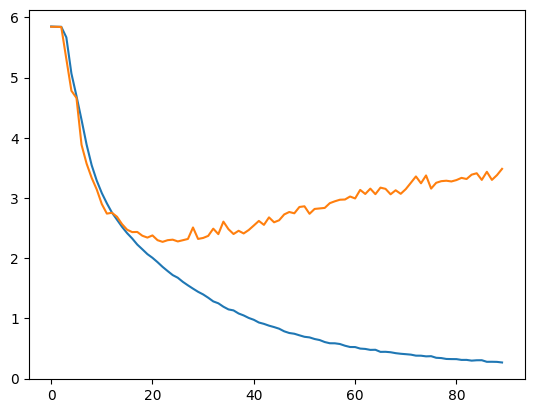

In [35]:
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), val_losses)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

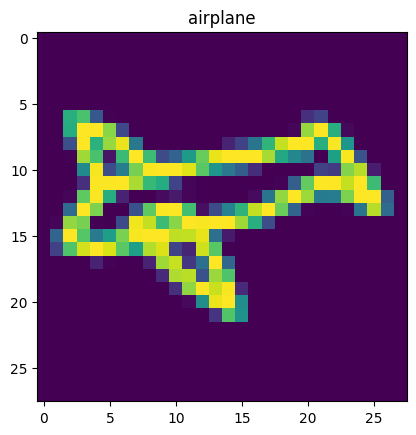

In [27]:
i = 101
img, label = train_set[i]
# print(img.shape)

plt.title(categories[label])
plt.imshow(img[0])

img = img.unsqueeze(0)

out = minialexnet(img)

print(out)

torch.argmax(out)

print(categories[label])

### Evaluate Model